TO Do
- Check value fresolution

In [2]:
import sys
sys.path.append(r'C:\Users\dpoppema\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05')
import os
import puv
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


In [6]:
# input specification
instrFile = r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S1ADV1 QC - period 1.nc"
ncOutFile = r"O:\HybridDune experiment\data ADV, OBS\processed\ADV S1ADV1 Processed data - period 1.nc"

# Ensure the input file exists
if not os.path.exists(instrFile):
    raise FileNotFoundError(f"The input file does not exist: {instrFile}")

# Ensure the output directory exists
out_dir = os.path.dirname(ncOutFile)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
     
# frequency resolution in fourier space
fresolution = 0.03125
#number of directional bins 
ntheta = 64
  
# load the raw data from netcdf
ds0 = xr.open_dataset(instrFile).load()


In [6]:
ds0

<xarray.Dataset> Size: 300MB
Dimensions:       (t: 145, N: 28720, t_theta: 2, t_zb: 5, t_zi: 2, zi: 2)
Coordinates:
  * t             (t) datetime64[ns] 1kB 2024-12-17T09:00:00 ... 2024-12-23T0...
  * N             (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03
  * t_theta       (t_theta) datetime64[ns] 16B 2024-12-17T09:00:00 2024-12-22...
  * t_zb          (t_zb) datetime64[ns] 40B 2024-12-17T11:30:00 ... 2024-12-2...
  * t_zi          (t_zi) datetime64[ns] 16B 2024-12-17T11:30:00 2024-12-21T14...
  * zi            (zi) float64 16B 0.953 0.731
    maskp         (t, N) bool 4MB True True True True ... False False False
    maskv         (t, N) bool 4MB False False False False ... True True True
    maskd         (t, N) bool 4MB False False False False ... False False True
Data variables: (12/44)
    sf            float64 8B 8.0
    u             (t, N) float64 33MB nan nan nan nan nan ... nan nan nan nan
    v             (t, N) float64 33MB nan nan nan nan nan ... nan nan nan nan
    w             (t, N) float64 33MB nan nan nan nan nan ... nan nan nan nan
    burst         (t, N) float64 33MB 97.0 97.0 97.0 97.0 ... 241.0 241.0 242.0
    pm            (t) float64 1kB 517.2 538.0 510.3 ... 2.932e+03 1.723e+03
    ...            ...
    zsmean        (t) float64 1kB 1.312 1.312 1.313 1.314 ... 1.46 1.476 1.382
    h             (t) float64 1kB 0.612 0.6123 0.6129 ... 0.9872 1.005 0.911
    C_OBShigh     (t, N) float64 33MB nan nan nan nan nan ... nan nan nan nan
    C_OBSlow      (t, N) float64 33MB nan nan nan nan nan ... nan nan nan nan
    mask_OBShigh  (t, N) bool 4MB True True True True ... True True True True
    mask_OBSlow   (t, N) bool 4MB True True True True ... True True True True
Attributes: (12/14)
    Conventions:               CF-1.6
    title:                     S1ADV1 raw data - period 1
    instrument:                Nortek Vector
    instrument serial number:  VEC13638
    connected OBS type:        Cambell OBS3+
    time zone:                 UTC+1
    ...                        ...
    contact person:            Daan Poppema
    emailadres:                d.w.poppema@tudelft.nl
    construction datetime:     08-Oct-2025 (19:02:59)
    version:                   v2
    version comments:          constructed with xarray
    comment:                   Quality checked data: pressure level corrected...

Text(0, 0.5, 'Percentage of NaNs (%)')

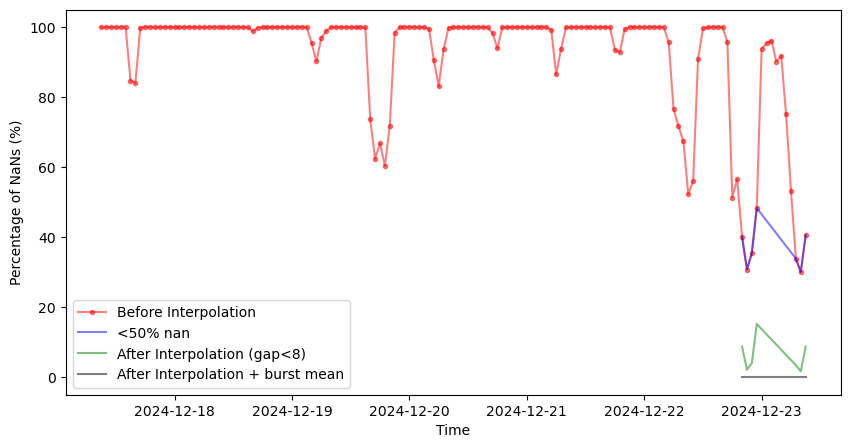

In [ ]:
# TEST, PLOT NAN FILTERING
ds0 = xr.open_dataset(instrFile).load() #Reload, to start with fresh data set again, without nan filtering
# interpolate nans
N = len(ds0.N)
for var in ['u', 'v', 'w', 'p', 'eta']:
    # interpolate the bursts where there is less than 5% nans
    data_old = ds0[var]
    data = ds0[var].where(
        np.isnan(ds0[var]).sum(dim='N') < 0.5 * len(ds0.N)   # Daan: temporary 50% isntead of 5%
    ).dropna(dim='t', how='all')  # make burstst with >5% nan completely nan, then drop burst with all nans
    if len(data.t) != 0: # if any burst remaining, fill gaps less than 8 in length with cubic interpolation
        data2 = data.interpolate_na(
            dim='N',
            method='cubic',
            max_gap=8)

    # and fill the gaps more than 8 in length with the burst average
    data3 = data2.fillna(ds0[var].mean(dim='N'))

# # Ensure no NaNs or infs are present
# for var in ['u', 'v', 'p', 'eta']:                                      # Ruben
#     ds0[var] = ds0[var].fillna(0).where(np.isfinite(ds0[var]), 0)       # Ruben
# ds0 = ds0.dropna(dim='t')                                               # TUD Coastal

# define p_old and p_new, with the percentage of nans per burst in data
p_old = 100 * np.isnan(data_old).sum(dim='N') / N
p_new = 100 * np.isnan(data).sum(dim='N') / N
p_new2 = 100 * np.isnan(data2).sum(dim='N') / N
p_new3 = 100 * np.isnan(data3).sum(dim='N') / N

# plot the percentage of nans before and after interpolation
plt.figure(figsize=(10, 5))
plt.plot(ds0.t, p_old, label='Before Interpolation', color='red', alpha=0.5, marker='o', markersize=3, linestyle='-')
plt.plot(data.t, p_new, label='<50% nan', color='blue', alpha=0.5)
plt.plot(data2.t, p_new2, label='After Interpolation (gap<8)', color='green', alpha=0.5)
plt.plot(data3.t, p_new3, label='After Interpolation + burst mean', color='black', alpha=0.5)
plt.xlabel('Time')
plt.legend()
plt.ylabel('Percentage of NaNs (%)')

In [9]:
# INTERPOLATE NANS IN VARIABLES
# For variables with t, N dimension. block-avgs don't need interpolation. NB: Concentration (C_OBShigh, C_OBSlow) are skipped here, they need special treatment to deal with clipping (S3.ADV2 at least, the others don't clip during otherwise valid ADV data collection)
for var in ['u', 'v', 'w', 'pc', 'eta']:                      
    # interpolate the bursts where there is less than 50% nans
    data = ds0[var].where(                                  
        np.isnan(ds0[var]).sum(dim='N') < 0.5 * len(ds0.N)    # first make bursts with >50% nan completely nan
        ).dropna(dim='t', how='all')                          # then drop bursts with all nans
    
    # if any burst remaining, fill gaps less than 3 seconds with cubic interpolation
    if len(data.t) != 0:                                    
        ds0[var] = data.interpolate_na(
            dim='N', method='cubic', max_gap=3)               # NB: gap width in seconds, not in number of samples

    # and fill the gaps more than 3 in length with the burst average
    ds0[var] = ds0[var].fillna(ds0[var].mean(dim='N'))

# Ensure no NaNs or infs are present
for var in ['u', 'v', 'w', 'pc', 'eta']:
    ds0[var] = ds0[var].fillna(0).where(np.isfinite(ds0[var]), 0)    # make blocks that are 100% nan (from code above) all zeros
#ds0 = ds0.dropna(dim='t')                                           # alternative: drop blocks. NB: this only works if the concentration is interpolated, otherwise those nans cause all blocks to be dropped. 


In [ ]:
# make a new dataset that has an extra dimension to accommodate for the frequency axis
ds = xr.Dataset(data_vars={},
          coords = {'t': ds0.t.values,
                    'N': ds0.N.values,
                    'f': np.arange(0, ds0.sf.values/2, fresolution),
                    'theta': np.arange(start=-np.pi, stop=np.pi, step=2*np.pi/ntheta)})
ds['f'].attrs = {'units': 'Hz'}
ds.attrs = ds0.attrs

# put all variables in this new dataset
for key in ds0.data_vars:
    ds[key] = ds0[key]

# extract sampling frequency as explicit variable
sf = ds.sf.values          

# compute water depth
ds['h'] = ds['zsmean'] - ds['zb']   

# do several wave statistics computations, only based on pressure
ufunc = lambda x, h: puv.attenuation_corrected_wave_spectrum(
    'pressure',
    ds.sf.values, np.nan_to_num(x), h,
    ds.zi.values,
    ds.zb.values,
    fresolution=fresolution)

fx, ds['vy'] = xr.apply_ufunc(ufunc,
                        ds['p'], ds['h'],
                        input_core_dims=[['N'], []],
                        output_core_dims=[['f'], ['f']],
                        vectorize=True) 
ds['vy'].attrs = {'units': 'm2/Hz', 'long_name': 'spectral density'}

ufunc = lambda vy: puv.get_peak_frequency(ds.f.values, np.nan_to_num(vy))
ds['fp'] = xr.apply_ufunc(ufunc,
                        ds['vy'],
                        input_core_dims=[['f']],
                        output_core_dims=[[]], 
                        vectorize=True) 

ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, np.nan_to_num(vy), fmin=0.5*fp, fmax=5)
ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['fp'],
                        input_core_dims=[['f'], []],
                        output_core_dims=[[], [], [], [], [], []],
                        vectorize=True) 
ds['Hm0'].attrs = {'units': 'm', 'long_name': 'significant wave height', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tp'].attrs = {'units': 's', 'long_name': 'peak wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm01'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm02'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tmm10'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tps'].attrs = {'units': 's', 'long_name': 'peak wave period', 'computation': 'computed between fmin=0.5fp and fmax=5', 'comment': 'smoothed estimate from the discrete spectrum'}

# compute current magnitudes and direction all computed in the time domain
ds['u_mean'] = ds.u.mean(axis=1)
ds['u_mean'].attrs = {'units': 'm/s', 'long_name': 'current x-component', 'computation': 'burst averaged'}

ds['v_mean'] = ds.v.mean(axis=1)
ds['v_mean'].attrs = {'units': 'm/s', 'long_name': 'current y-component', 'computation': 'burst averaged'}

ds['cur_dir'] = np.arctan2(ds['v_mean'], ds['u_mean']) * 180 / np.pi
ds['cur_dir'].attrs = {'units': 'deg', 'long_name': 'current direction, cartesian convention'}

# directional wave spectra
ufunc = lambda p, u, v, h, fp: puv.wave_MEMpuv(np.nan_to_num(p/1e4), np.nan_to_num(u), np.nan_to_num(v), h,
                    ds.zi.values,
                    ds.zb.values,
                    ds.sf.values,
                    fresolution=fresolution,
                    ntheta=ntheta,
                    fcorrmin=0.5*fp,
                    fcorrmax=5,
                    maxiter=20)

fx, vy, theta, ds['S'] = xr.apply_ufunc(ufunc,
                        ds['p'], ds['u'], ds['v'], ds['h'], ds['fp'],
                        input_core_dims=[['N'], ['N'], ['N'], [], []],
                        output_core_dims=[['f'], ['f'], ['theta'], ['f', 'theta']],
                        vectorize=True) 
ds['S'].attrs = {'units': 'm2/Hz/rad', 'long_name': 'directional variance density',
                 'computation': 'computed between fmin=0.5fp and fmax=5'}

# statistics from directional wave spectra
ufunc = lambda vy, S, fp: puv.compute_wave_params(ds.f.values, np.nan_to_num(vy), fmin=0.5*fp, fmax=5, theta=ds.theta.values, S=np.nan_to_num(S))
Hm0, Tp, Tm01, Tm02, Tmm10, Tps, ds['wavedirmean'], ds['dirspread'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['S'], ds['fp'],
                        input_core_dims=[['f'], ['f', 'theta'], []],
                        output_core_dims=[[], [], [], [], [], [], [], []],
                        vectorize=True) 
ds['wavedirmean'].attrs = {'units': 'deg', 'long_name': 'mean wave direction', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['dirspread'].attrs = {'units': 'deg', 'long_name': 'directional spreading', 'computation': 'computed between fmin=0.5fp and fmax=5'}

# write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
dsTailored = ds.drop_dims('N')

<xarray.Dataset> Size: 304MB
Dimensions:       (t: 145, N: 28720, f: 128, t_theta: 2, t_zb: 5, t_zi: 2)
Coordinates:
  * t             (t) datetime64[ns] 1kB 2024-12-17T09:00:00 ... 2024-12-23T0...
  * N             (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03
  * f             (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
    theta         (t_theta) float64 16B 304.9 312.6
    maskp         (t, N) bool 4MB True True True True ... False False False
    maskv         (t, N) bool 4MB False False False False ... True True True
    maskd         (t, N) bool 4MB False False False False ... False False True
    maskd2        (t, N) bool 4MB True True True True ... True False False True
  * t_theta       (t_theta) datetime64[ns] 16B 2024-12-17T09:00:00 2024-12-22...
  * t_zb          (t_zb) datetime64[ns] 40B 2024-12-17T11:30:00 ... 2024-12-2...
  * t_zi          (t_zi) datetime64[ns] 16B 2024-12-17T11:30:00 2024-12-21T14...
Data variables: (12/43)
    sf            float

In [ ]:

# extract sampling frequency as explicit variable
sf = ds.sf.values          

# compute water depth
ds['h'] = ds['zsmean'] - ds['zb']   

# do several wave statistics computations, only based on pressure
ufunc = lambda x, h: puv.attenuation_corrected_wave_spectrum(
    'pressure',
    ds.sf.values, np.nan_to_num(x), h,
    ds.zi.values,
    ds.zb.values,
    fresolution=fresolution)

fx, ds['vy'] = xr.apply_ufunc(ufunc,
                        ds['p'], ds['h'],
                        input_core_dims=[['N'], []],
                        output_core_dims=[['f'], ['f']],
                        vectorize=True) 
ds['vy'].attrs = {'units': 'm2/Hz', 'long_name': 'spectral density'}

ufunc = lambda vy: puv.get_peak_frequency(ds.f.values, np.nan_to_num(vy))
ds['fp'] = xr.apply_ufunc(ufunc,
                        ds['vy'],
                        input_core_dims=[['f']],
                        output_core_dims=[[]], 
                        vectorize=True) 

ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, np.nan_to_num(vy), fmin=0.5*fp, fmax=5)
ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['fp'],
                        input_core_dims=[['f'], []],
                        output_core_dims=[[], [], [], [], [], []],
                        vectorize=True) 
ds['Hm0'].attrs = {'units': 'm', 'long_name': 'significant wave height', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tp'].attrs = {'units': 's', 'long_name': 'peak wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm01'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm02'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tmm10'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tps'].attrs = {'units': 's', 'long_name': 'peak wave period', 'computation': 'computed between fmin=0.5fp and fmax=5', 'comment': 'smoothed estimate from the discrete spectrum'}

# compute current magnitudes and direction all computed in the time domain
ds['u_mean'] = ds.u.mean(axis=1)
ds['u_mean'].attrs = {'units': 'm/s', 'long_name': 'current x-component', 'computation': 'burst averaged'}

ds['v_mean'] = ds.v.mean(axis=1)
ds['v_mean'].attrs = {'units': 'm/s', 'long_name': 'current y-component', 'computation': 'burst averaged'}

ds['cur_dir'] = np.arctan2(ds['v_mean'], ds['u_mean']) * 180 / np.pi
ds['cur_dir'].attrs = {'units': 'deg', 'long_name': 'current direction, cartesian convention'}

# directional wave spectra
ufunc = lambda p, u, v, h, fp: puv.wave_MEMpuv(np.nan_to_num(p/1e4), np.nan_to_num(u), np.nan_to_num(v), h,
                    ds.zi.values,
                    ds.zb.values,
                    ds.sf.values,
                    fresolution=fresolution,
                    ntheta=ntheta,
                    fcorrmin=0.5*fp,
                    fcorrmax=5,
                    maxiter=20)

fx, vy, theta, ds['S'] = xr.apply_ufunc(ufunc,
                        ds['p'], ds['u'], ds['v'], ds['h'], ds['fp'],
                        input_core_dims=[['N'], ['N'], ['N'], [], []],
                        output_core_dims=[['f'], ['f'], ['theta'], ['f', 'theta']],
                        vectorize=True) 
ds['S'].attrs = {'units': 'm2/Hz/rad', 'long_name': 'directional variance density',
                 'computation': 'computed between fmin=0.5fp and fmax=5'}

# statistics from directional wave spectra
ufunc = lambda vy, S, fp: puv.compute_wave_params(ds.f.values, np.nan_to_num(vy), fmin=0.5*fp, fmax=5, theta=ds.theta.values, S=np.nan_to_num(S))
Hm0, Tp, Tm01, Tm02, Tmm10, Tps, ds['wavedirmean'], ds['dirspread'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['S'], ds['fp'],
                        input_core_dims=[['f'], ['f', 'theta'], []],
                        output_core_dims=[[], [], [], [], [], [], [], []],
                        vectorize=True) 
ds['wavedirmean'].attrs = {'units': 'deg', 'long_name': 'mean wave direction', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['dirspread'].attrs = {'units': 'deg', 'long_name': 'directional spreading', 'computation': 'computed between fmin=0.5fp and fmax=5'}

# write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
dsTailored = ds.drop_dims('N')

In [7]:
#dsTailored.to_netcdf(ncOutFile)

# specify compression for all the variables to reduce file size
comp = dict(zlib=True, complevel=5)
dsTailored.encoding = {var: comp for var in list(dsTailored.data_vars) + list(dsTailored.coords)}

dsTailored.to_netcdf(ncOutFile, encoding = dsTailored.encoding)


In [8]:
print(dsTailored)

<xarray.Dataset> Size: 17MB
Dimensions:      (t: 249, f: 128, theta: 64)
Coordinates:
  * t            (t) datetime64[ns] 2kB 2024-12-13T10:00:00 ... 2024-12-23T18...
  * f            (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
Data variables: (12/37)
    sf           float64 8B 8.0
    pm           (t) float64 2kB 4.833e+03 4.807e+03 ... 4.289e+03 4.456e+03
    um           (t) float64 2kB -0.08855 -0.1802 -0.2578 ... 0.03344 0.07954
    vm           (t) float64 2kB -0.1344 -0.1052 -0.141 ... -0.1773 -1.07
    wm           (t) float64 2kB 0.04796 0.06976 0.09734 ... 0.03272 -0.01249
    anl1m        (t) float64 2kB 2.0 2.0 2.0 2.0 2.0 ... 33.7 370.1 2.0 2.0
    ...           ...
    u_mean       (t) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v_mean       (t) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cur_dir      (t) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.

In [51]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the tailored NetCDF file
# ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"
# ds = xr.open_dataset(ncOutFile)

# Print the dataset structure to understand what variables are available
print(ds)

<xarray.Dataset> Size: 349MB
Dimensions:      (t: 168, N: 28720, f: 128, theta: 64)
Coordinates:
  * t            (t) datetime64[ns] 1kB 2024-12-16T13:00:00 ... 2024-12-23T12...
  * N            (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
  * f            (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
    maskp        (t, N) bool 5MB True True True True ... True True True True
    maskv        (t, N) bool 5MB False False False False ... False False False
    maskd        (t, N) bool 5MB False False False False ... False False False
Data variables: (12/50)
    sf           float64 8B 8.0
    p            (t, N) float64 39MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    u            (t, N) float64 39MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v            (t, N) float64 39MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    w            (t, N) float64 39MB nan nan nan nan

In [52]:
ds

<xarray.Dataset> Size: 349MB
Dimensions:      (t: 168, N: 28720, f: 128, theta: 64)
Coordinates:
  * t            (t) datetime64[ns] 1kB 2024-12-16T13:00:00 ... 2024-12-23T12...
  * N            (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
  * f            (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
    maskp        (t, N) bool 5MB True True True True ... True True True True
    maskv        (t, N) bool 5MB False False False False ... False False False
    maskd        (t, N) bool 5MB False False False False ... False False False
Data variables: (12/50)
    sf           float64 8B 8.0
    p            (t, N) float64 39MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    u            (t, N) float64 39MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v            (t, N) float64 39MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    w            (t, N) float64 39MB nan nan nan nan nan ... nan nan nan nan nan
    anl1         (t, N) float64 39MB 247.0 250.0 253.0 255.0 ... 0.0 0.0 0.0 0.0
    ...           ...
    u_mean       (t) float64 1kB 0.0 0.0 0.0 0.0 0.0 ... -0.6311 -0.494 0.0 0.0
    v_mean       (t) float64 1kB 0.0 0.0 0.0 0.0 0.0 ... 0.03466 -0.1529 0.0 0.0
    cur_dir      (t) float64 1kB 0.0 0.0 0.0 0.0 0.0 ... 176.9 -162.8 0.0 0.0
    S            (t, f, theta) float64 11MB 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wavedirmean  (t) float64 1kB 0.0 0.0 0.0 0.0 0.0 ... 284.3 80.36 0.0 0.0
    dirspread    (t) float64 1kB nan nan nan nan nan ... nan 67.51 78.31 nan nan
Attributes: (12/16)
    Conventions:               CF-1.6
    title:                     ADV_RWS1_Deployment1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     12-Feb-2025 (09:22:33)
    version:                   v2
    version comments:          constructed with xarray
    comment:                   Quality checked data: pressure reference level...

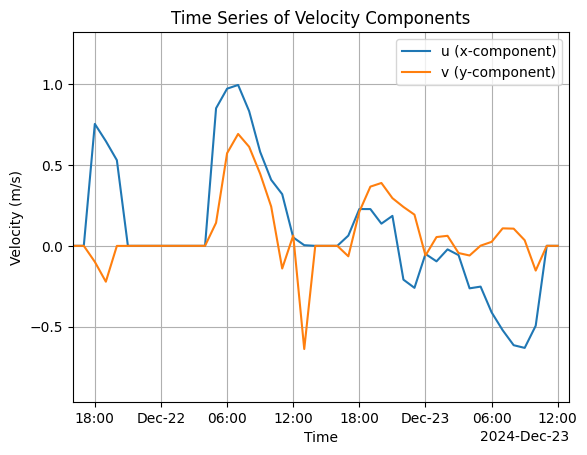

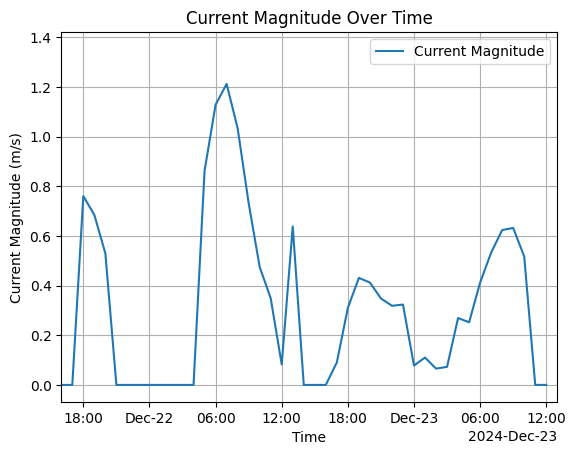

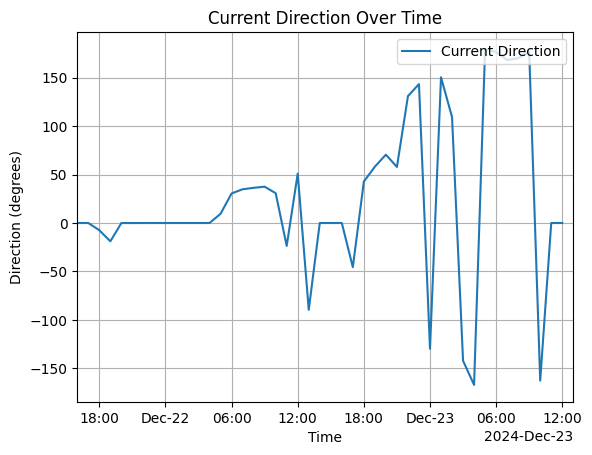

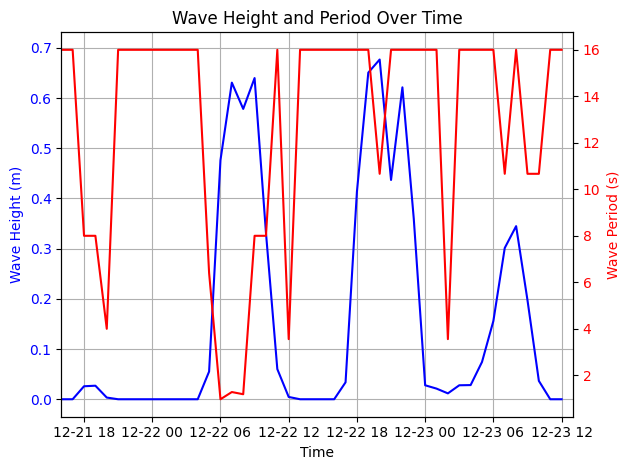

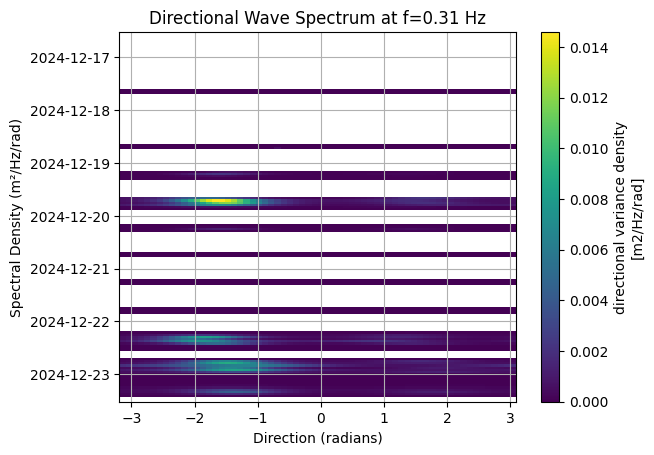

c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 168, using nperseg = 168
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


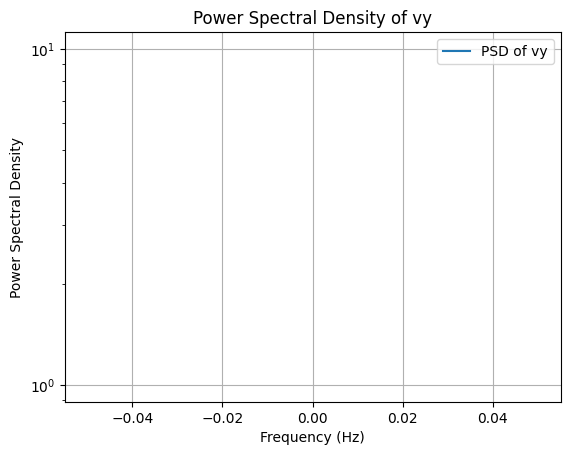

In [61]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the tailored NetCDF file
# ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"
# ds = xr.open_dataset(ncOutFile)
 
# Print the dataset structure to understand what variables are available
# ds

# # Set x-axis limits using specific date stamps
# start_time = pd.Timestamp("2024-12-21T16:00:00")
# end_time = pd.Timestamp("2024-12-23T13:00:00")
# plt.xlim(start_time, end_time)

# 1. Time Series of Velocity Components (u_mean, v_mean)
if 'u_mean' in ds and 'v_mean' in ds:
    ds['u_mean'].plot(label="u (x-component)")
    ds['v_mean'].plot(label="v (y-component)")
    plt.title("Time Series of Velocity Components")
    plt.xlabel("Time")
    plt.ylabel("Velocity (m/s)")
    plt.legend(loc='upper right')
    start_time = pd.Timestamp("2024-12-21T16:00:00")
    end_time = pd.Timestamp("2024-12-23T13:00:00")
    plt.xlim(start_time, end_time)
    plt.grid()
    plt.show()

# 2. Current Magnitude and Direction
if 'u_mean' in ds and 'v_mean' in ds:
    current_magnitude = np.sqrt(ds['u_mean']**2 + ds['v_mean']**2)
    current_magnitude.plot(label="Current Magnitude")
    plt.title("Current Magnitude Over Time")
    plt.xlabel("Time")
    plt.ylabel("Current Magnitude (m/s)")
    plt.legend(loc='upper right')
    start_time = pd.Timestamp("2024-12-21T16:00:00")
    end_time = pd.Timestamp("2024-12-23T13:00:00")
    plt.xlim(start_time, end_time)
    plt.grid()
    plt.show()

    if 'cur_dir' in ds:
        ds['cur_dir'].plot(label="Current Direction")
        plt.title("Current Direction Over Time")
        plt.xlabel("Time")
        plt.ylabel("Direction (degrees)")
        plt.legend(loc='upper right')
        start_time = pd.Timestamp("2024-12-21T16:00:00")
        end_time = pd.Timestamp("2024-12-23T13:00:00")
        plt.xlim(start_time, end_time)
        plt.grid()
        plt.show()

# 3. Wave Height (Hm0) and Wave Period (Tp)
if 'Hm0' in ds and 'Tp' in ds:
    fig, ax1 = plt.subplots()

    # Plot Hm0 on the primary y-axis
    ax1.plot(ds['t'], ds['Hm0'], label="Hm0 (Wave Height)", color='b')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Wave Height (m)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot Tp on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(ds['t'], ds['Tp'], label="Tp (Wave Period)", color='r')
    ax2.set_ylabel("Wave Period (s)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title("Wave Height and Period Over Time")
    fig.tight_layout()
    start_time = pd.Timestamp("2024-12-21T16:00:00")
    end_time = pd.Timestamp("2024-12-23T13:00:00")
    ax1.set_xlim(start_time, end_time)
    ax2.set_xlim(start_time, end_time)
    ax1.grid()
    plt.show()

# 4. Directional Wave Spectrum (S)
if 'S' in ds:
    freq_idx = 10  # Select a specific frequency index for the example
    if freq_idx < len(ds['f']):
        ds['S'].isel(f=freq_idx).plot(x='theta', yincrease=False)
        plt.title(f"Directional Wave Spectrum at f={ds['f'][freq_idx].values:.2f} Hz")
        plt.xlabel("Direction (radians)")
        plt.ylabel("Spectral Density (m²/Hz/rad)")
        plt.grid()
        plt.show()

# 5. Power Spectral Density (vy)
if 'vy' in ds:
    from scipy.signal import welch

    # Compute PSD for 'vy' component
    fs = ds.sf.values if 'sf' in ds else 1.0  # Sampling frequency
    f, Pxx = welch(ds['vy'].mean(dim='f'), fs=fs, nperseg=256)

    plt.semilogy(f, Pxx, label="PSD of vy")
    plt.title("Power Spectral Density of vy")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

